Cross-Validated Average AUC: 0.92


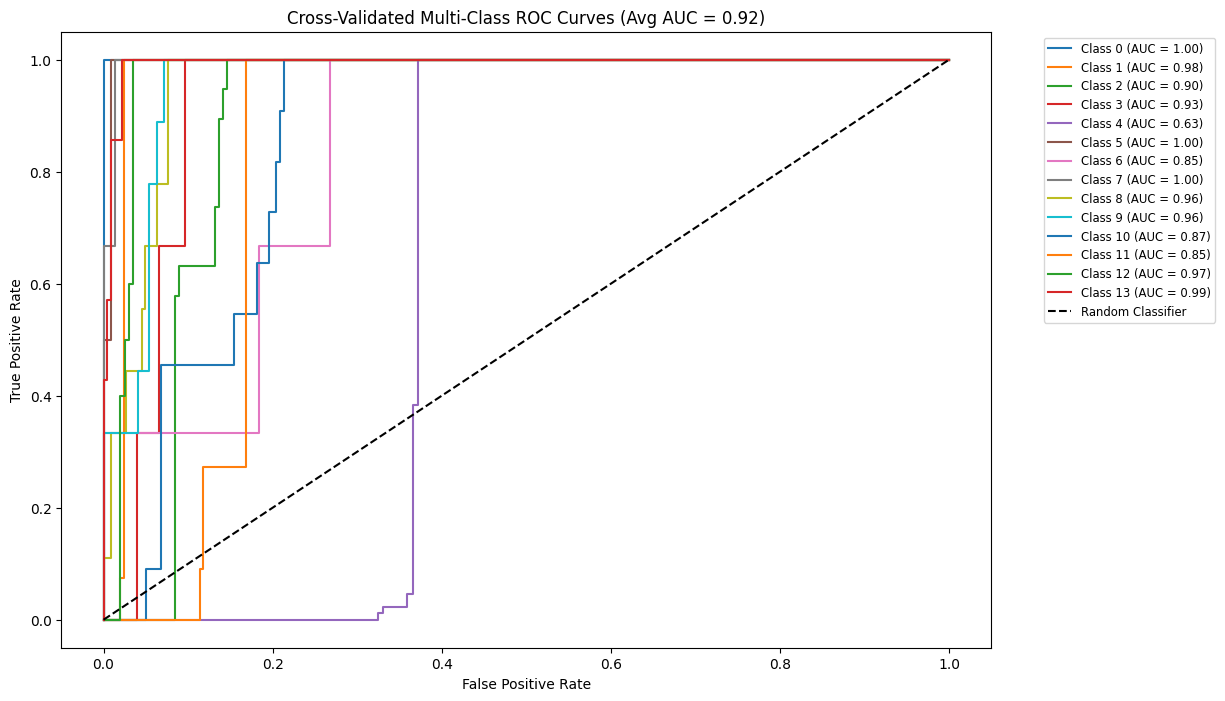

Average Confusion Matrix:
 [[ 4.4  0.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 2.2 24.6  0.4  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.4 18.4  0.4  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.6  3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  85.4  0.6  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.2  7.6  0.2  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.6  2.2  0.2  0.2  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.6  1.4  0.4  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.8  7.6  0.4  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.6  7.8  0.4  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2  9.6  0.6  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.8 10.2  0.2  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.4  0.2 28.8  1. ]
 [ 0.   0.   0.   0.   0

NameError: name 'gene_mapping' is not defined

<Figure size 800x600 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Define the NeuralNet class (same as before)
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Load the dataset
df = pd.read_csv("/Users/raghav/Documents/GitHub/ACSEF/filteredmin10.csv")

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Encode target variable
le_genes = LabelEncoder()
df["MostVariableGene_Encoded"] = le_genes.fit_transform(df["MostVariableGene"].astype(str))

# Define features and target
X = df.drop(columns=["MostVariableGene", "case_id", "project_id", "icd_10_code"], errors='ignore')
y = df["MostVariableGene_Encoded"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection: Keep only the top 15 features based on feature importance from RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Get feature importances and sort them
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Select top 15 most important features
top_15_features = feature_importances["Feature"][:8].tolist()
X_selected = df[top_15_features]

# Normalize selected features
X_scaled_selected = scaler.fit_transform(X_selected)

# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
all_conf_matrices = []  # To store confusion matrices
all_metrics = []  # To store overall metrics (accuracy, precision, recall, etc.)

for train_index, test_index in kf.split(X_scaled_selected, y):
    X_train, X_test = X_scaled_selected[train_index], X_scaled_selected[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Handle class imbalance with SMOTE
# Set sampling_strategy to ensure all classes (0 to 13) have the same number of samples (430)
    smote = SMOTE(sampling_strategy={i: 430 for i in range(14)}, random_state=42, k_neighbors=1)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the model
    num_classes = len(np.unique(y_train))
    input_size = X_train.shape[1]
    model = NeuralNet(input_size, num_classes)

    # Compute class weights
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
    class_weights[0] *= 0.5
    class_weights[13] *= 0.5
    class_weights[4] *= 1.5
    class_weights[5] *= 0.5
    class_weights[6] *=1.5
    class_weights[10] *= 1.5
    class_weights[7] *= 0.5

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the model
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    y_true, y_pred_prob = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            y_true.extend(targets.numpy())
            y_pred_prob.extend(outputs.numpy())

    # Convert predictions to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute AUC for each fold
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    y_pred_prob = np.array(y_pred_prob)

    fold_auc_scores = []
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        fold_auc_scores.append(auc(fpr, tpr))

    # Store mean AUC for this fold
    auc_scores.append(np.mean(fold_auc_scores))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    all_conf_matrices.append(conf_matrix)

    # Compute overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Sensitivity and Specificity
    TP = conf_matrix[1, 1]  # True Positive
    TN = conf_matrix[0, 0]  # True Negative
    FP = conf_matrix[0, 1]  # False Positive
    FN = conf_matrix[1, 0]  # False Negative

    sensitivity = TP / (TP + FN)  # True Positive Rate
    specificity = TN / (TN + FP)  # True Negative Rate

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity
    }
    all_metrics.append(metrics)

# Compute and print final cross-validated AUC
final_avg_auc = np.mean(auc_scores)
print(f"Cross-Validated Average AUC: {final_avg_auc:.2f}")

# Plot ROC Curves for all classes after cross-validation
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {fold_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Cross-Validated Multi-Class ROC Curves (Avg AUC = {final_avg_auc:.2f})')
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.05, 1))
plt.show()

# Display average confusion matrix and overall metrics
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
print("Average Confusion Matrix:\n", avg_conf_matrix)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=gene_mapping.values(), yticklabels=gene_mapping.values())
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display overall metrics (accuracy, precision, recall, F1 score, sensitivity, specificity)
avg_metrics = {metric: np.mean([m[metric] for m in all_metrics]) for metric in all_metrics[0]}
print("Average Metrics:", avg_metrics)


                     Feature  Importance
25  MostVariableGene_Encoded    0.419670
24      MeanDecreaseAccuracy    0.198967
1              days_to_birth    0.034774
9           age_at_diagnosis    0.033152
7              year_of_birth    0.028571
0               age_at_index    0.028353
22         year_of_diagnosis    0.025503
16    days_to_last_follow_up    0.023295
2              days_to_death    0.021703
13         ajcc_pathologic_t    0.020408


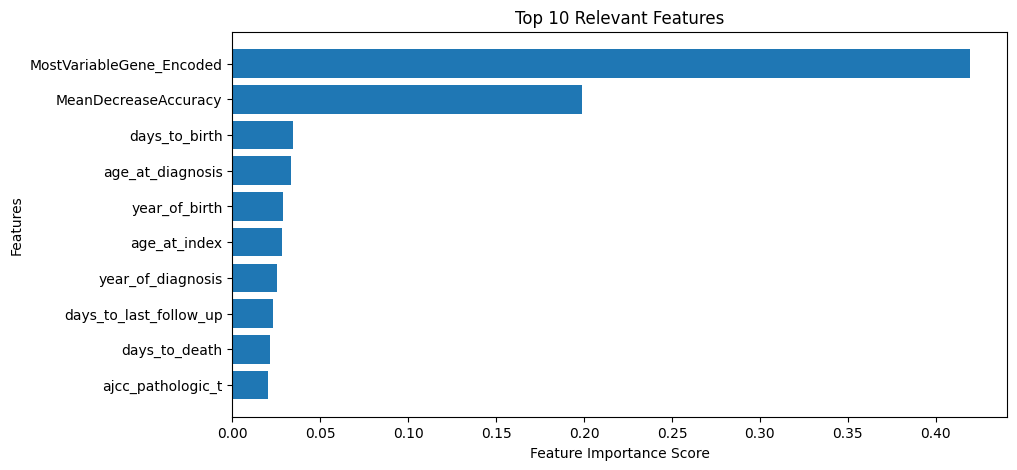

In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train a Random Forest model to get feature importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display the top relevant features
print(feature_importance_df.head(10))  # Show top 10 most important features

# Plot feature importances
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df["Feature"][:10], feature_importance_df["Importance"][:10], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Relevant Features")
plt.show()


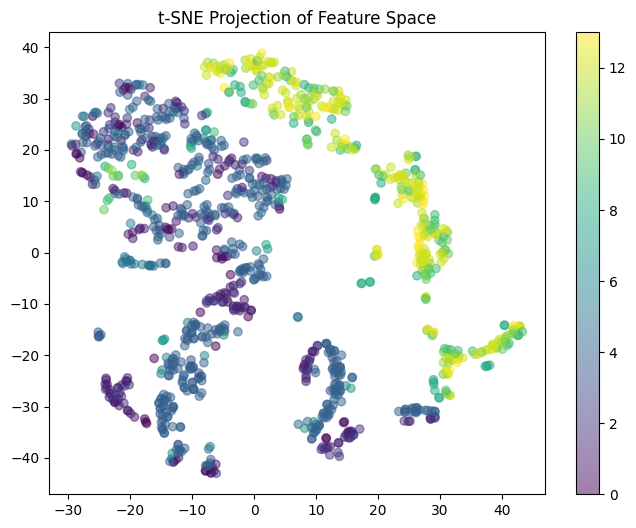

In [2]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="viridis", alpha=0.5)
plt.colorbar()
plt.title("t-SNE Projection of Feature Space")
plt.show()
